In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Load all JSON data files
with open('top_womens_names.json', 'r') as f:
    womens_names = json.load(f)

with open('top_mens_names.json', 'r') as f:
    mens_names = json.load(f)

with open('resumes_to_rank.json', 'r') as f:
    resumes_data = json.load(f)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Define category meanings for clarity
category_meanings = {
    'W': 'White/Caucasian',
    'B': 'Black/African American',
    'A': 'Asian',
    'H': 'Hispanic/Latino'
}

# 1. NAME DATA ANALYSIS

In [ ]:
def names_to_df(names_dict, gender):
    data = []
    for category, names_list in names_dict.items():
        for full_name in names_list:
            parts = full_name.split()
            if len(parts) >= 2:
                first_name = parts[0]
                last_name = " ".join(parts[1:])
                data.append({
                    'first_name': first_name,
                    'last_name': last_name,
                    'full_name': full_name,
                    'category': category,
                    'category_name': category_meanings.get(category, category),
                    'gender': gender
                })
    return pd.DataFrame(data)

Total women's names: 400
Total men's names: 400
Combined total names: 800


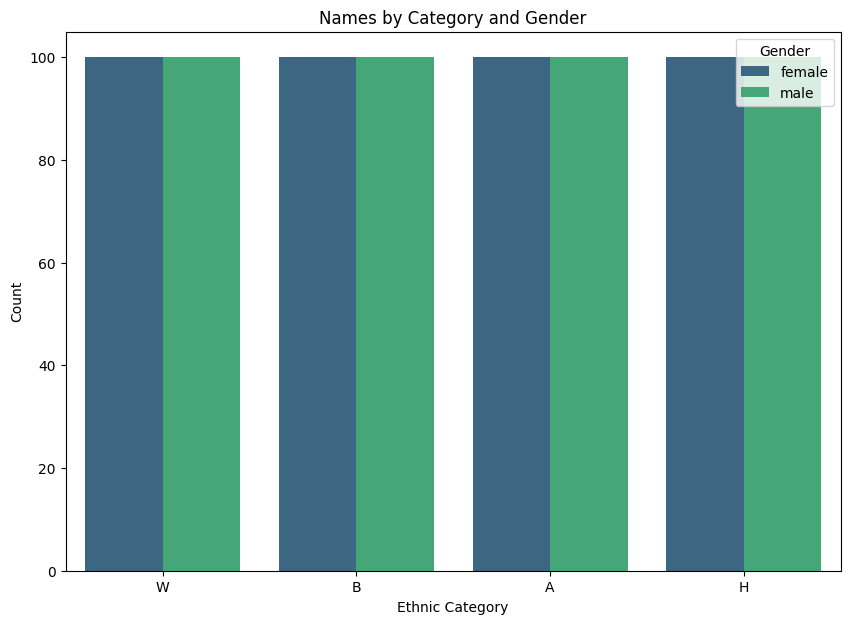

In [ ]:
women_df = names_to_df(womens_names, 'female')
men_df = names_to_df(mens_names, 'male')
all_names_df = pd.concat([women_df, men_df])

print(f"Total women's names: {len(women_df)}")
print(f"Total men's names: {len(men_df)}")
print(f"Combined total names: {len(all_names_df)}")

# Distribution of names by category and gender
plt.figure(figsize=(10, 7))
sns.countplot(x='category', hue='gender', data=all_names_df, palette='viridis')
plt.title('Names by Category and Gender')
plt.xlabel('Ethnic Category')
plt.ylabel('Count')
plt.legend(title='Gender')

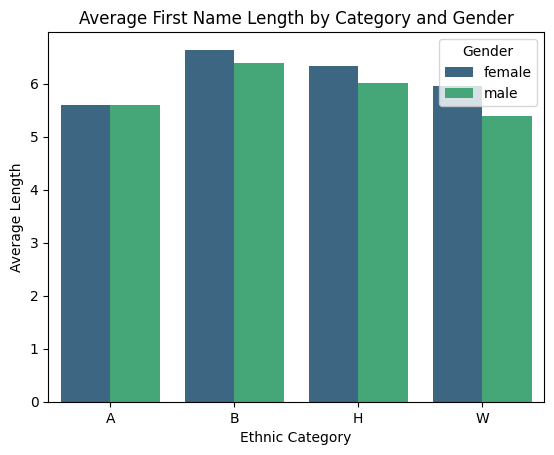

In [ ]:
# Name length analysis
all_names_df['first_name_length'] = all_names_df['first_name'].apply(len)
all_names_df['last_name_length'] = all_names_df['last_name'].apply(len)

# Plot average name lengths by category and gender
name_length_by_group = all_names_df.groupby(['category', 'gender'])['first_name_length'].mean().reset_index()
sns.barplot(x='category', y='first_name_length', hue='gender', data=name_length_by_group, palette='viridis')
plt.title('Average First Name Length by Category and Gender')
plt.xlabel('Ethnic Category')
plt.ylabel('Average Length')
plt.legend(title='Gender')


<ipython-input-28-e02d98fe24cc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=letter_counts.index, y=letter_counts.values, palette='viridis')


Text(0, 0.5, 'Count')

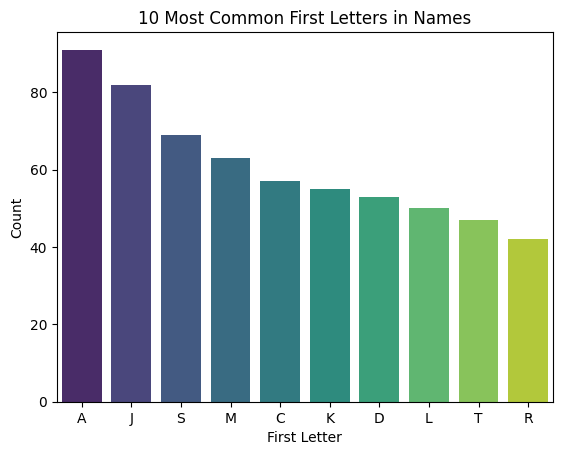

In [ ]:
# First letter distribution
all_names_df['first_letter'] = all_names_df['first_name'].str[0]
letter_counts = all_names_df['first_letter'].value_counts().head(10)
sns.barplot(x=letter_counts.index, y=letter_counts.values, palette='viridis')
plt.title('10 Most Common First Letters in Names')
plt.xlabel('First Letter')
plt.ylabel('Count')

<ipython-input-30-b7d7ad365b8f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=last_name_counts.index, y=last_name_counts.values, palette='viridis')


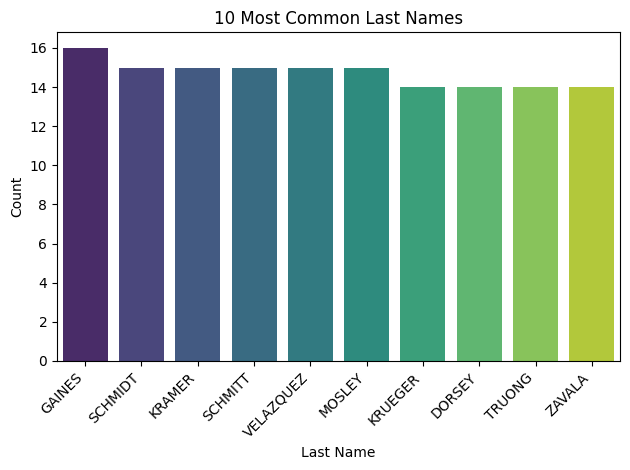

In [ ]:
# Common last names
last_name_counts = all_names_df['last_name'].value_counts().head(10)
sns.barplot(x=last_name_counts.index, y=last_name_counts.values, palette='viridis')
plt.title('10 Most Common Last Names')
plt.xlabel('Last Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()

## 2. RESUME DATA ANALYSIS

In [ ]:
print(f"Number of job positions: {len(resumes_data)}")
job_positions = list(resumes_data.keys())
print(f"Job positions: {job_positions}")

# Create a DataFrame to hold resume data
resume_df_list = []

for position in job_positions:
    job_data = resumes_data[position]
    job_desc = job_data['jd']
    job_url = job_data['jd_url']

    for i, resume in enumerate(job_data['resumes']):
        # Calculate resume length and complexity metrics
        word_count = len(re.findall(r'\w+', resume))
        sentence_count = len(re.findall(r'[.!?]+', resume))

        resume_df_list.append({
            'position': position,
            'resume_id': i + 1,
            'resume_text': resume,
            'job_desc': job_desc,
            'job_url': job_url,
            'word_count': word_count,
            'sentence_count': sentence_count,
            'words_per_sentence': word_count / max(1, sentence_count)
        })

resume_df = pd.DataFrame(resume_df_list)

Number of job positions: 4
Job positions: ['software engineer', 'HR specialist', 'retail', 'financial analyst']


In [ ]:
# Basic resume stats by position
resume_stats = resume_df.groupby('position').agg({
    'word_count': ['mean', 'min', 'max'],
    'sentence_count': ['mean', 'min', 'max'],
    'words_per_sentence': 'mean'
}).reset_index()

print("\nResume statistics by job position:")
print(resume_stats)


Resume statistics by job position:
            position word_count           sentence_count          \
                           mean  min  max           mean min max   
0      HR specialist    152.125  123  174          9.375   8  14   
1  financial analyst    165.125  125  207         11.375   6  18   
2             retail    149.000  121  169          8.000   2  10   
3  software engineer    159.125  130  190         10.375   3  15   

  words_per_sentence  
                mean  
0          17.191621  
1          15.735534  
2          24.278819  
3          19.851297  


<ipython-input-34-31f72237de12>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='position', y='word_count', data=resume_df, palette='viridis')


([0, 1, 2, 3],
 [Text(0, 0, 'software engineer'),
  Text(1, 0, 'HR specialist'),
  Text(2, 0, 'retail'),
  Text(3, 0, 'financial analyst')])

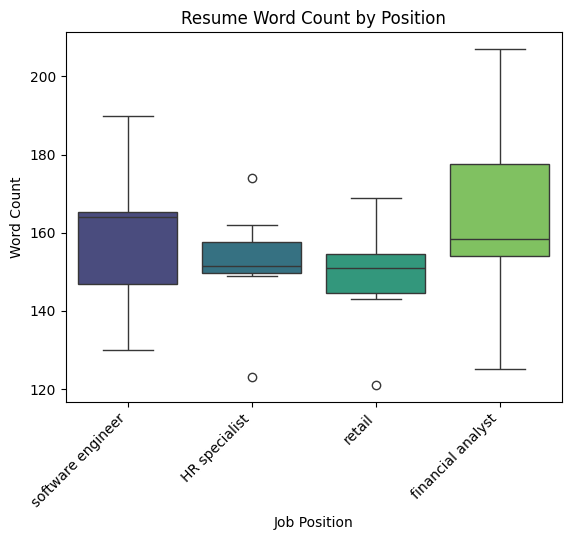

In [ ]:
# Visualize resume word counts by position
sns.boxplot(x='position', y='word_count', data=resume_df, palette='viridis')
plt.title('Resume Word Count by Position')
plt.xlabel('Job Position')
plt.ylabel('Word Count')
plt.xticks(rotation=45, ha='right')